<a href="https://colab.research.google.com/github/aCStandke/ReinforcementLearning/blob/main/ActorCriticAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actor-Critic 

Actor-Critic methods are [TD learning](https://en.wikipedia.org/wiki/Temporal_difference_learning) methods that represent the policy function independent of the value function.

A policy function (or policy) returns a probability distribution over actions that the agent can take based on the given state. A value function determines the expected return for an agent starting at a given state and acting according to a particular policy forever after.

In the Actor-Critic method, the policy is referred to as the actor that proposes a set of possible actions given a state, and the estimated value function is referred to as the critic, which evaluates actions taken by the actor based on the given policy.




# Importing and Setting up the Lunar Lander environment

In [62]:
!pip install gym --upgrade
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
import gym
env = gym.make("LunarLander-v2",continuous = False ,gravity = -10.0,enable_wind = False,wind_power = 15.0,turbulence_power = 1.5,)

/usr/local/lib/python3.7/dist-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [64]:
!sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [65]:
import collections
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers

In [66]:
# Set seed for experiment reproducibility
seed = 42
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

/usr/local/lib/python3.7/dist-packages/gym/core.py:269: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


# Building Actor Critic Model

The Actor and Critic will be modeled using one neural network that generates the action probabilities and critic value respectively. Meaning that θ<sub>k</sub> is the only paramater.

The paper [Actor-Critic Algorithms](https://proceedings.neurips.cc/paper/1999/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) has another paramater for the critic z<sub>k</sub> which represents [Sutton's eligibility trace](https://paperswithcode.com/method/eligibility-trace).


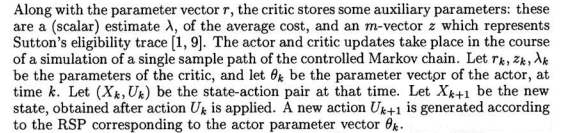





In [67]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self, 
      num_actions, 
      num_hidden_units):
    """Initialize."""
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs):
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

In [68]:
num_actions = 4
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

In [69]:
num_actions = env.action_space.shape
num_actions

()

# Training

To train the agent, you will follow these steps:
1.   Run the agent on the environment to collect training data per episode
2.   Compute expected return at each time step.
3.   Compute the loss for the combined actor-critic model.
4.   Compute gradients and update network parameters.
5.   Repeat 1-4 until either success criterion or max episodes has been reached.


###### Step 1: Collect Training Data


> As in supervised learning, in order to train the actor-critic model, you need to have training data. However, in order to collect such data, the model would need to be "run" in the environment.

> Training data is collected for each episode. Then at each time step, the model's forward pass will be run on the environment's state in order to generate action probabilities and the critic value based on the current policy parameterized by the model's weights.

> The next action will be sampled from the action probabilities generated by the model, which would then be applied to the environment, causing the next state and reward to be generated.

> This process is implemented in the run_episode function, which uses TensorFlow operations so that it can later be compiled into a TensorFlow graph for faster training. Note that tf.TensorArrays were used to support Tensor iteration on variable length arrays.

In [70]:
# Wrap OpenAI Gym's 'env.step' call as an operation in a TensorFlow function.
# This allows it to be included in a TensforFlow graph

# python function
# action: np.ndarray
def env_step(action):
  state, reward, done, _ = env.step(action)
  return (state.astype(np.float32), np.array(reward, np.int32), np.array(done, np.int32))

'''
tf.numpy_function: wraps a python function and uses it as a TensorFlow op.
Given a python function func tf wraps this function as an op 
in a TensorFlow function. func must take numpy arrays as its arguments and
return numpy arrays as its outputs
'''
# tensorflow function
# action: tf.Tensor 
def tf_env_step(action):
  return tf.numpy_function(env_step, [action], [tf.float32, tf.int32, tf.int32])


In [71]:
# initial_step: tf.Tensor
# model: tf.keras.Model
# max_steps: int
def run_episode(initial_state, model, max_steps):
  '''
  tf.TensorArray: class that wraps dynamic-sized, per-time-step, write-once 
  Tensor arrays.This class is meant to be used with dynamic iteration primitives
  such as while_loop and map_fn.  It supports gradient back-propagation via 
  special "flow" control flow dependencies.
  '''
  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  # setting the shape and initial state
  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    # convert state into a batched tensor (batch =1)
    '''tf.expand_dims: returns a tensor with a length 1 axis inserted at index axis'''
    state = tf.expand_dims(state, 0)

    # run the model, to get logits representing actions and the critic value
    action_logits_t, value = model(state)
    # sample from a categorical distribution the next action logits
    action = tf.random.categorical(action_logits_t, num_samples=1)[0,0]
    # transform into action probablities
    action_probs_t = tf.nn.softmax(action_logits_t)
    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])

    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)

    # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()

  return action_probs, values, rewards

###### Step 2: Calculate Expected Return 

> The sequence of rewards i.e. **r** for each timestep **t** collected during one episode is converted into a sequence of expected returns **G** in which the sum of rewards is taken from the current timestep **t** to **T** and each rewards is multiplied with an exponentially decaying discount facter **γ** in which rewards further out from the current timestep are given less weight.  

> Intuitivley, expected return simply implies that rewards now are better than rewards later. In a mathematical sense, it is to ensure that the sum of the rewards converges. To stabilize training, the resulting sequence of returns is also standardized (i.e. to have zero mean and unit standard deviation).

In [72]:
# rewards: tf.Tensor
# gamma: float
# standardize: bool
def get_expected_return(rewards, gamma, standardize=True):
  '''Compute expected returns per timestep'''
  n = tf.shape(rewards)[0]
  # set tensor array that is the size of the first dim of rewards
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  '''calculating expected return portion of the formula'''
  # start by geting last values from the rewards array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  # initializing the discounted sum portion
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape =  discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma *discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  '''standarizing returns to have zero mean and unit std deviation '''
  if standardize:
    returns = ((returns-tf.math.reduce_mean(returns))/(tf.math.reduce_std(returns)+ eps))
  
  return returns

###### Step 3: Calculate Actor-Critic Loss

Since a hybrid actor-critic model is used, the chosen loss function is a combination of actor and critic losses for training, as below:

L = L<sub>actor</sub> + L<sub>critic</sub>

###### Actor Loss:

> The actor loss is based on policy gradients with the critic as a state dependent baseline. Using the critic as a state dependent baseline in the Actor loss, gives a better estimator that is not only unbiased but also a lower variance than just using G. This fact is detailed in the slide below, in which b is replaced by the critic V, leading to the following advantage function [A<sup>π</sup>](https://jonathan-hui.medium.com/rl-basics-algorithms-and-terms-ae98314851d7):

> 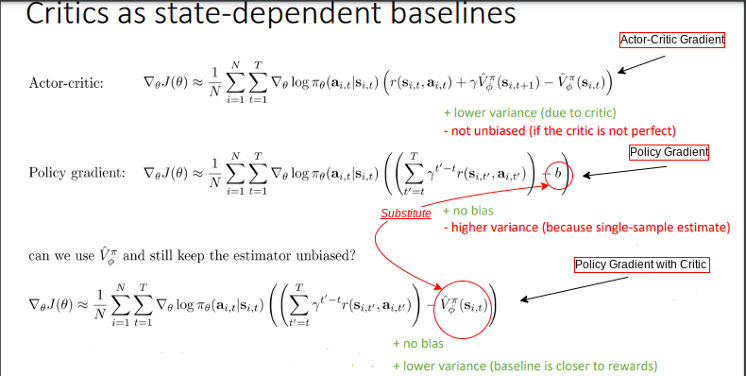

> Image comes from lecture on [Actor-Critic Algorithms](http://rail.eecs.berkeley.edu/deeprlcourse-fa17/f17docs/lecture_5_actor_critic_pdf)

> where:
*   *N*: Batch Size
*   *T*: Number of timesteps per episode (⭐ may vary per episode!)
*   *s*<sub>t</sub>: state at timestep t
*   *a*<sub>t</sub>: action at timestep t given state s
*   *π*<sub>θ</sub>: policy/actor with weights given by θ
*   *V*<sub>θ</sub><sup>π</sup>: value/critic with weights given by θ (rather than ϕ, since this is a shared network where the weights are shared between Actor and Critic)
*    *∑*<sub>t'=t</sub>γ<sup>t'-t</sup>r( **s**<sub>i,t'</sub>, **a**<sub>i,t'</sub>) ≡ **G**<sub>t</sub>: expected return for given (state,action) pair at timestep t


###### Critic Loss:

> Training **V**<sub>θ</sub><sup>π</sup> to be as close possible to **G**<sub>t</sub> can be set up as a regression problem with the following loss function:

> **L**<sub>𝛿</sub>(**V**<sub>θ</sub><sup>π</sup>,**G**<sub>t</sub>)

> where **L**<sub>𝛿</sub> is the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which is a loss piecewise function used in robust regression that is less sensitive to outliers in data than the [squared error loss](https://en.wikipedia.org/wiki/Loss_function#Quadratic_loss_function). It is defined by the variable *x* which represents the residuals errors and a threshold value called 𝛿

In [73]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

# action_probs: tf.Tensor
# values: tf.Tensor
# returns: tf.Tensor
def compute_loss(action_probs,values, returns):
  # advantage ie. G-V 
  advantage = returns - values
  # policy ie. log(a|s)
  action_log_probs = tf.math.log(action_probs)
  # Actor loss calculation
  actor_loss = -tf.math.reduce_mean(action_log_probs*advantage)
  # Critic loss calculation
  critic_loss = huber_loss(values, returns)
  
  return actor_loss + critic_loss


###### Step 4: Defining the training step to update parameters

> All of the steps above are combined into a training step that is run every episode. All steps leading up to the loss function are executed with the **tf.GradientTape** context to enable automatic differentiation.

> Then the gradients and optimizer executed. Additionally, the sum of the undiscounted rewards, *episode_reward* is also computed. This value will be used later on to evaluate if the success criterion is met.

> The **tf.function** context is applied to the train_step function so that it can be compiled into a callable TensorFlow graph, which can lead to 10x speedup in training.

In [74]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# intial_state: tf.Tensor
# model: tf.keras.Model
# optimizer: tf.keras.optimizers.Optimizer
# gamma: float
# max_steps_per_episode: int
@tf.function
def train_step(initial_state,model, optimizer, gamma, max_steps_per_episode):
  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(initial_state, model, max_steps_per_episode) 

    # Calculate expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

    # Calculating loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward

###### Step 5: Run the training loop

> Training is executed by running the training step until either the success criterion or maximum number of episodes is reached.

> A running record of episode rewards is kept in a queue. Once 100 trials are reached, the oldest reward is removed at the left (tail) end of the queue and the newest one is added at the head (right). A running sum of the rewards is also maintained for computational efficiency.

In [75]:
%time

min_episodes_criterion = 100
max_episodes = 10000
max_steps_per_episode = 1000

# lunar lander is considered solved if average reward is >=200 points over 100 
# consecutive trials
reward_threshold = 200
running_reward = 0

# Discount factor for future rewards
gamma = 0.99

# Keep last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

with tqdm.trange(max_episodes) as t:
  for i in t:
    initial_state = tf.constant(env.reset(), dtype=tf.float32)
    episode_reward = int(train_step(initial_state, model, optimizer, gamma, max_steps_per_episode))

    episodes_reward.append(episode_reward)
    running_reward = statistics.mean(episodes_reward)

    t.set_description(f'Episode {i}')
    t.set_postfix(episode_reward=episode_reward, running_reward=running_reward)

    if running_reward > reward_threshold and i >= min_episodes_criterion:  
        break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


Episode 9999: 100%|██████████| 10000/10000 [5:05:07<00:00,  1.83s/it, episode_reward=221, running_reward=116]


Solved at episode 9999: average reward: 115.82!


In [76]:
# Render an episode and save as a GIF file
from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display


display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env, model, max_steps): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]

  state = tf.constant(env.reset(), dtype=tf.float32)
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, _, done, _ = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))

    if done:
      break

  return images


# Save GIF image
images = render_episode(env, model, max_steps_per_episode)
image_file = 'Discrete_lunerlander.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

/usr/local/lib/python3.7/dist-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "



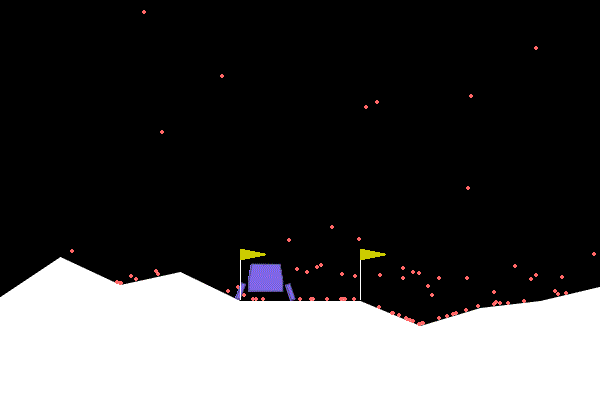

In [77]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)